In [1]:
# Imports
%pylab inline
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../../src')
from helpers import *
from plothelpers import *
from BayesianNamingGame import *
from matplotlib import gridspec
from scipy.stats import linregress

import os
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Preprocessing

In [2]:
def find_critical_points(df, xs=None, indices=False):
    """Identifies the critical points in a simulation run.
    The critical points are the maximum of JSD(*phis)
    and the intersection of JSD(alpha, mean(*phis)). The critical
    points are identified by their time, t_max and t_int resp,
    and their index i_max and i_int in the list of times.
    
    Args:
        df: a Pandas dataframe or a numpy array
        xs: if df is a numpy array, then the times xs should be passed
        indices: return indices rather than times?
    
    Returns:
        (t_max, t_int) if indices == False
        (i_max, i_int) if indices == True
    """
    if type(df) == np.ndarray:
        phis = df[:,0]
        alpha_mphi = df[:,1]
    else:
        xs = array(df.index)
        phis = df['JSD(*phis)']
        alpha_mphi = df['JSD(alpha, mean(*phis))']
    
    # Maximum
    if type(df) == np.ndarray:
        i_max = phis.argmax()
        t_max = xs[i_max]
    else:
        t_max = phis.argmax()
        i_max = list(xs).index(t_max)
    
    try:
        # Intersection of JSD(phis) and JSD(alpha_mphi)
        i_int = np.argwhere(np.diff(np.sign(phis - alpha_mphi)) != 0).reshape(-1).min()
        t_int = xs[i_int]
    except: 
        print('>>> Could not find intersection!')
        t_int = np.nan
        i_int = np.nan

    if indices:
        return i_max, i_int
    else:
        return t_max, t_int

In [3]:
# Load and preprocess all data: find critical points
results = { 'b': {}, 'K':{}, 'N': {}}
params = {
    'b': [1, 2, 5, 10, 20, 50, 100],
    'K': [5, 50, 100, 150, 200],
    'N': [5, 50, 100, 150, 200] }

for param in params.keys():
    for value in params[param]: 
        print(f'Working on {param}={value}')
        results[param][value] = { 
            'stats': [], 
            't_max':[], 'v_max': [],
            't_int':[], 'v_int': [] }
        
        for run in range(1,21):
            fn = f'../../results/BNG03/BNG03-{param}-{value}-run-{run:0>4}'
            res = load_BNG_simulation(fn)
            if run == 1:
                results[param][value]['params'] = res  
            df = res['stats']
            assert res[param] == value
            
            # Get and store critical points
            t_max, t_int = find_critical_points(df)
            results[param][value]['t_max'].append(t_max)
            results[param][value]['v_max'].append(df['JSD(*phis)'][t_max])

            if np.isnan(t_int):
                results[param][value]['t_int'].append(np.nan)
                results[param][value]['v_int'].append(np.nan)
            else:
                results[param][value]['t_int'].append(t_int)
                results[param][value]['v_int'].append(df['JSD(*phis)'][t_int])
            
            # Store stats, only for demo
            results[param][value]['stats'].append(res['stats'])
        
        for key in ['t_max', 'v_max', 't_int', 'v_int']:
            results[param][value][key] = array(results[param][value][key])
        

Working on b=1
Working on b=2
Working on b=5
Working on b=10
Working on b=20
Working on b=50
Working on b=100
Working on K=5
Working on K=50
Working on K=100
Working on K=150
Working on K=200
Working on N=5
Working on N=50
Working on N=100
Working on N=150
>>> Could not find intersection!
>>> Could not find intersection!
>>> Could not find intersection!
>>> Could not find intersection!
>>> Could not find intersection!
>>> Could not find intersection!
>>> Could not find intersection!
>>> Could not find intersection!
>>> Could not find intersection!
>>> Could not find intersection!
Working on N=200
>>> Could not find intersection!
>>> Could not find intersection!
>>> Could not find intersection!
>>> Could not find intersection!
>>> Could not find intersection!
>>> Could not find intersection!
>>> Could not find intersection!
>>> Could not find intersection!
>>> Could not find intersection!
>>> Could not find intersection!
>>> Could not find intersection!
>>> Could not find intersection!


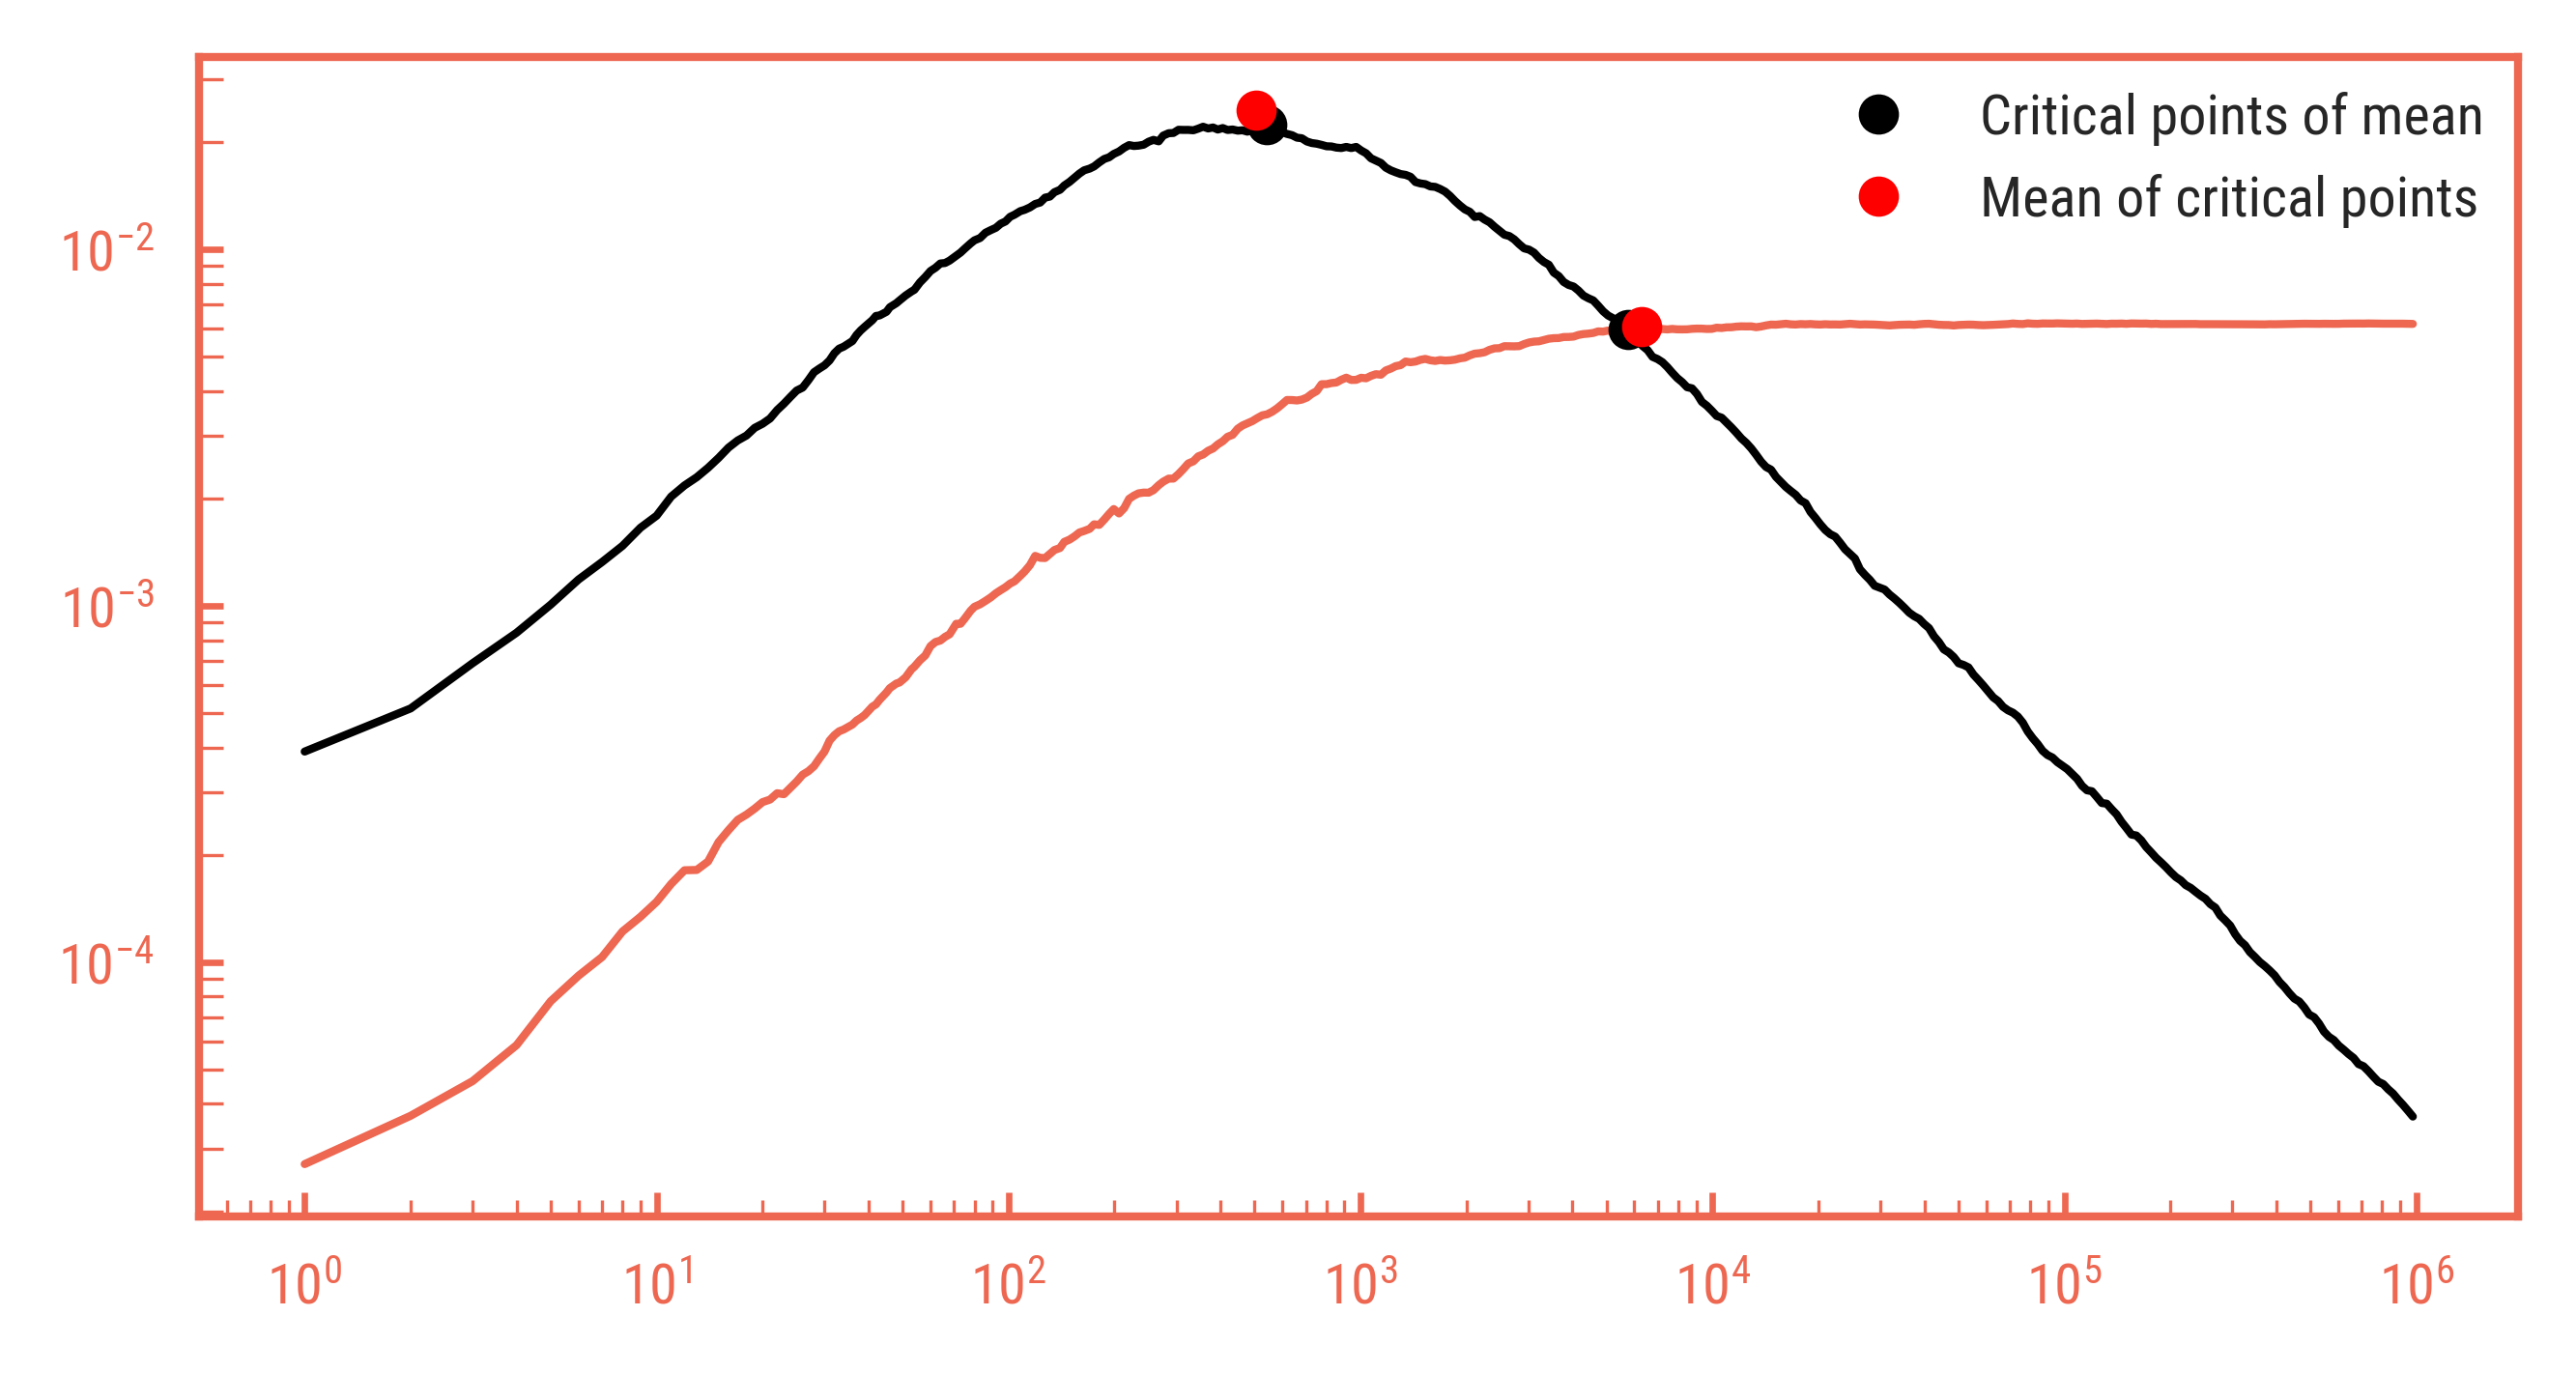

In [4]:
# Demo
figure(figsize=(4,2))

# Prepare all data
ex = results['b'][1]
means = array([df.as_matrix() for df in ex['stats']]).mean(axis=0)
phis = means[:,0]
alpha_mphi = means[:,1]
xs = ex['stats'][0].index

# Plot divergences
pyplot.loglog(xs, phis)
plot(xs, alpha_mphi)

# Max and intersection of mean (black)
i_max, i_int = find_critical_points(means, xs, indices=True)
plot(xs[i_max], phis[i_max], 'ko', ms=5)
plot(xs[i_int], phis[i_int], 'ko', ms=5, label='Critical points of mean')

# Mean max and intersection (red)
plot(ex['t_max'].mean(), ex['v_max'].mean(), 'ro', ms=5)
plot(ex['t_int'].mean(), ex['v_int'].mean(), 'ro', ms=5,
        label='Mean of critical points')
    
legend()

In [5]:
# Dump all data; only critical points
export = []
for param in params.keys():
    for value in params[param]: 
        for run in range(20):
            t_max = results[param][value]['t_max'][run]
            v_max = results[param][value]['v_max'][run]
            t_int = results[param][value]['t_int'][run]
            v_int = results[param][value]['v_int'][run]
            
            export.append([param, value, run+1, t_max, v_max, t_int, v_int])
            
points_df = pd.DataFrame(export, columns=['param', 'value', 'run', 't_max', 'v_max', 't_int', 'v_int'])
points_df.to_csv('../../results/BNG07/critical-points.csv')
points_df.to_csv('critical-points.csv')

# Analyze results

In [2]:
points = pd.read_csv('critical-points.csv', index_col=0)
points.set_index(['param', 'value', 'run'], inplace=True);
means = points.mean(axis=0, level=[0,1])

## Individual plots

In [3]:
# Effect of k
def plot_K(ax, means):

    # Maximum
    l, = plot(means.loc['K', 't_max'], '-',  lw=1,
              color=get_color('orange'),
              label='$t_{\mathsf{max}}$')
    vs = points.loc['K',:]['t_max'].unstack()
    plot(vs, 'o', alpha=.3, color=l.get_color());

    # Intersections
    l, = plot(means.loc['K', 't_int'], 'k-', lw=1,
             label='$t_{\mathsf{int}}$')
    vs = points.loc['K',:]['t_int'].unstack()
    plot(vs.index+2, vs, 'o', alpha=.3, color=l.get_color());
    ylim(0,800)

    ylabel('critical point ($t$)')
    xlabel('num words ($K$)')
    ax.yaxis.grid()
    legend(bbox_to_anchor=(.5,.4))

In [4]:
# ax1 = gca()
# plot_K(ax1, means)

In [10]:
# Effect of b
def plot_b(ax, means):
    # Max
    l, = pyplot.loglog(means.loc['b', 't_max'], '-',  lw=1,
                       color=get_color('orange'), label='')
    vs = points.loc['b',:]['t_max'].unstack()
    plot(vs, 'o', alpha=.3, color=l.get_color(), ms=2);

    # Intersection
    l, = pyplot.loglog(means.loc['b', 't_int'], 'k-', lw=1, label='')
    vs = points.loc['b',:]['t_int'].unstack()
    plot(vs, 'o', alpha=.3, color=l.get_color(), ms=2);
    
    # Linear regression
    pairs = array([(b, t_int) for (b, _), t_int in 
                   points.loc['b',:]['t_int'].items()])
    bs = pairs[:, 0]
    t_ints = pairs[:, 1]

    regr = linregress(log10(bs), log10(t_ints))
    a, k = regr.intercept, regr.slope
    pyplot.loglog(bs, bs**k * 10**a, 'k', dashes=(2,1),
                  color=get_color('blue'), lw=1.5,
                  label=f'$f(N) = {a:.1f}N^{{ {k:.2f} }}$')

    ylim(0,1e4)
    bs = means.loc['b'].index
    xticks(bs, bs)
    ax.yaxis.grid()
    ylabel('critical point ($t$)')
    xlabel('bottleneck ($b$)')
    legend()

In [6]:
# ax2 = gca()
# plot_b(ax2, means)

In [11]:
# Effect of N
def plot_N(ax, means):
    # Max
    l, = pyplot.loglog(means.loc['N', 't_max'], '-', lw=1,
                       color=get_color('orange'), label='')
    vs = points.loc['N',:]['t_max'].unstack()
    plot(vs, 'o', alpha=.3, color=l.get_color());

    # Intersection
    l, = pyplot.loglog(means.loc['N', 't_int'], 'k-', lw=1, label='')
    vs = points.loc['N',:]['t_int'].unstack()
    plot(vs, 'o', alpha=.3, color=l.get_color());
    
    # Linear regression
    pairs = array([(n, t_int) for (n, _), t_int in 
               points.loc['N',:]['t_int'].items() if not np.isnan(t_int) ])
    ns = pairs[:, 0]
    t_ints = pairs[:, 1]

    regr = linregress(log10(ns), log10(t_ints))
    a, k = regr.intercept, regr.slope
    pyplot.loglog(ns, ns**k * 10**a, 'k', dashes=(2,1),
                  color=get_color('blue'), lw=1.5,
                  label=f'$f(b) = {a:.1f}b^{{ {k:.2f} }}$')

    bs = means.loc['N'].index
    xticks(bs, bs)
    ax.yaxis.grid()
    ylabel('critical point ($t$)')
    xlabel('population size ($N$)')
    legend()

In [8]:
# ax2 = gca()
# plot_N(ax2, means)

## Combined plot

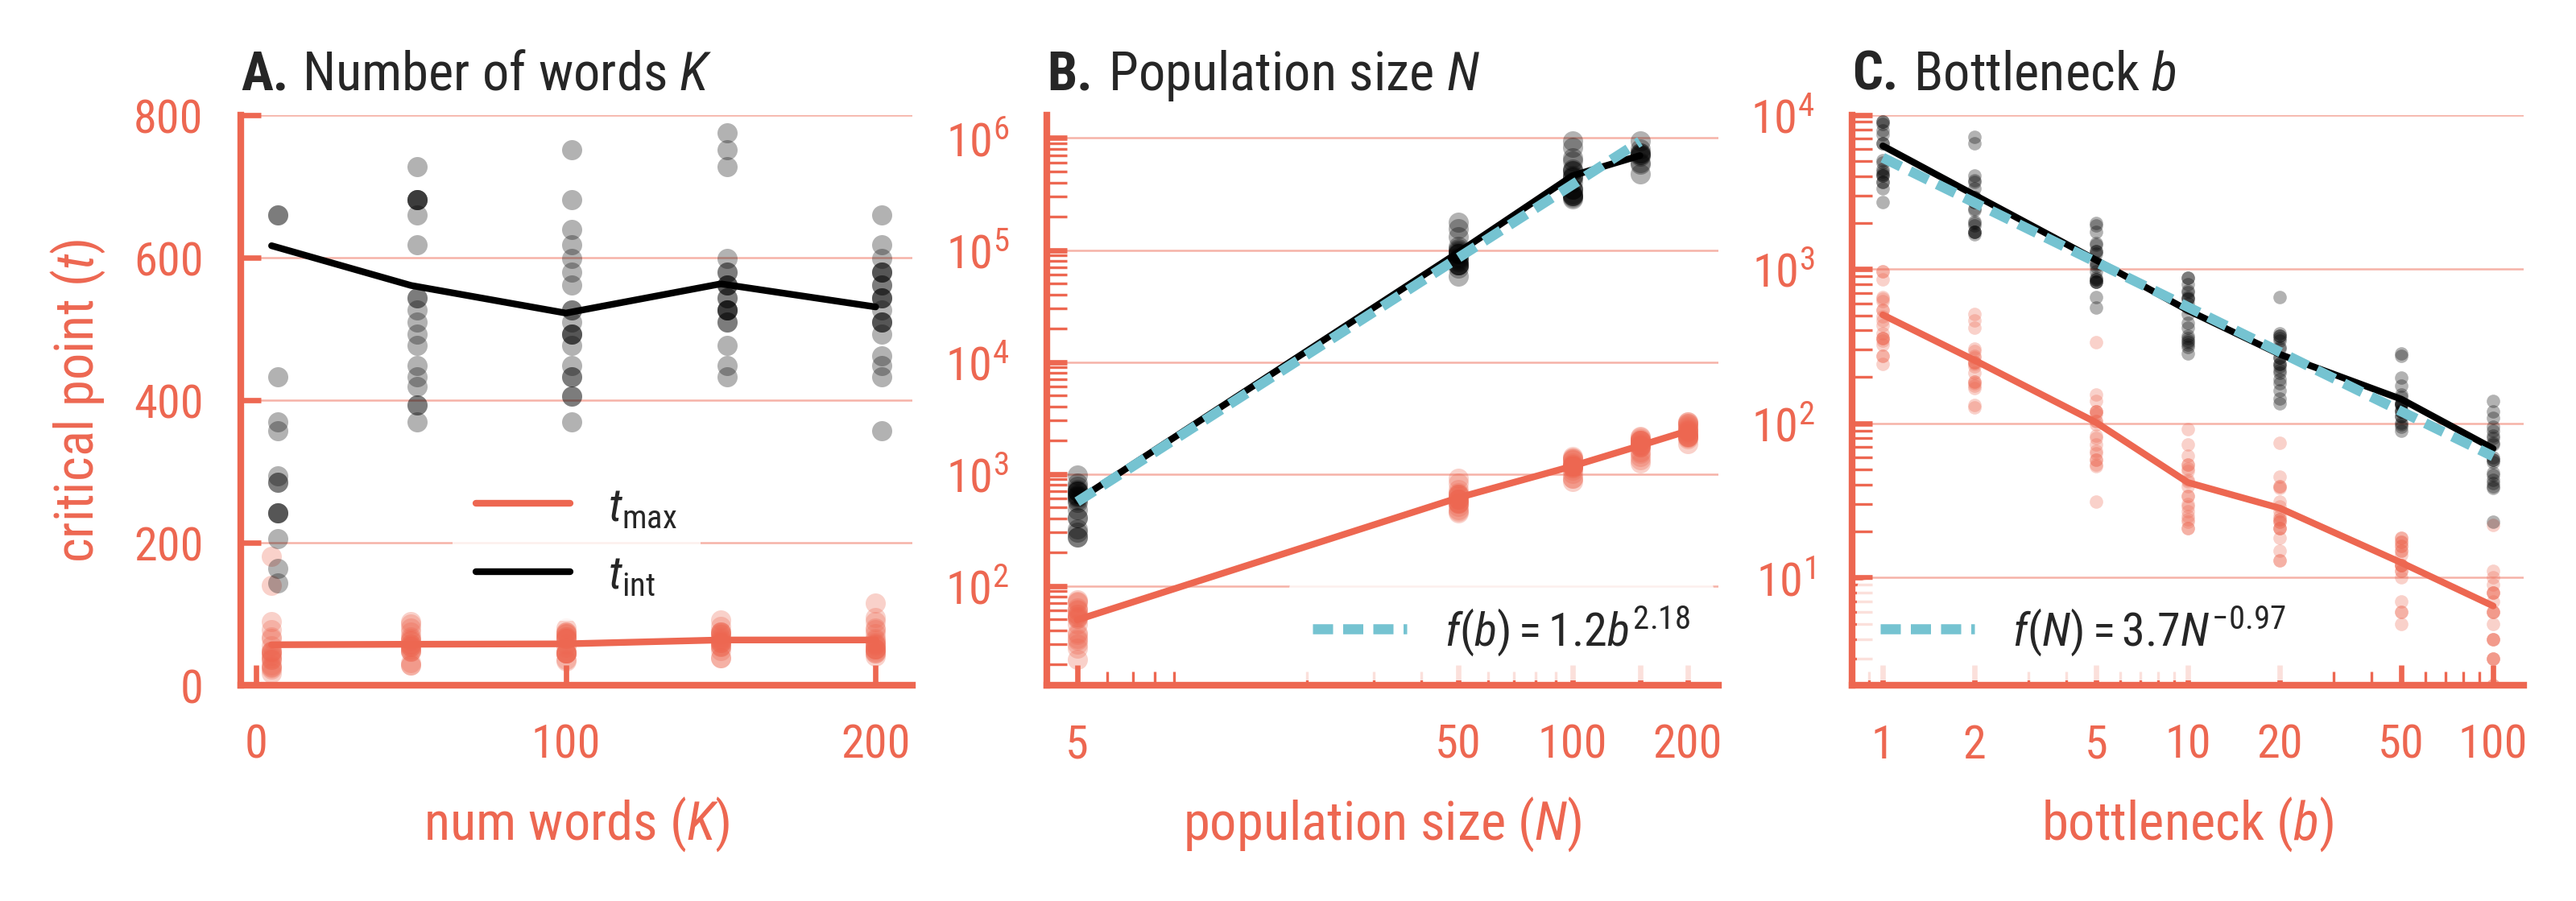

In [12]:
# plot
figure(figsize=cm2inch(12,3))
ax1 = subplot(131)
plot_K(ax1, means)
title('Number of words $K$')

ax2 = subplot(132)
plot_N(ax2, means)
title('Population size $N$')
ylabel('')

ax3 = subplot(133)
plot_b(ax3, means)
title('Bottleneck $b$')
ylabel('')

# Format 
restyle_title(ax1,ax2,ax3)
bs_labels = means.loc['N'].index.tolist()
bs_labels[3]= ''
ax2.set_xticklabels(bs_labels)
sns.despine()

subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=.5)
savefig('BNG03-effects-params-on-convergence.pdf', bbox_inches='tight')
copyfig('BNG03-effects-params-on-convergence.pdf')